# generatingFakeReadsForTesting.ipynb
## Marcus Viscardi,    September 02, 2022

I want to try and do some simple read generation with just text "parsing" and the expected read sequences

The main goal would be to make a simple function that could take an expected read sequence identity and then spit out a crapload of altered reads that could be used for testing and such!

In [216]:
import mappy
import mappy as mp
from pprint import pprint
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Union, List, Tuple, Any
import random
from nanoporePipelineCommon import find_newest_matching_file, pick_libs_return_paths_dict, get_dt
import textwrap

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_columns", None)
print("imports done")

imports done


### Load the standards fasta file into a dictionary:

In [3]:
reference_fasta = "/data16/marcus/scripts/nanoporePipelineScripts/standardsAlignment/220902_version2.0_releventSequences.fasta"

finalStandards_dict = {}
for read_id, sequence, quality, comments in mp.fastx_read(reference_fasta, read_comment=True):
    if "finalStandard" in read_id:
        finalStandards_dict[read_id] = (sequence, comments)

### Create methods for generating fake reads and plotting mappy alignments

In [217]:
def sequence_subindel_creater(seq,
                              insert_prob=0.01,
                              delete_prob=0.01,
                              sub_prob=0.05,
                              indel_size_factor=1.0,
                              upseq_truncate_prob=0.001,
                              downseq_truncate_prob=0.001) -> Tuple[Any, Tuple[Any, Any, Any]]:
    # TODO: Add ability to output multiple sequences
    seq = seq.upper()
    adjusted_seq = ""
    choices_per_nt = {"insert": insert_prob,
                      "delete": delete_prob,
                      "substitute": sub_prob,
                      "upseq_trunc": upseq_truncate_prob,
                      "downseq_trunc": downseq_truncate_prob,
                      "nothing": 1 - (insert_prob + delete_prob + sub_prob)}
    indel_sizes = [i+1 for i in range(25)]
    indel_weights = [10**((indel_size_factor * -i)+1) for i in range(25)]
    nucleotide_choices = ['G', 'C', 'T', 'A']
    
    has_been_truncated = False
    trunc_pos = 0
    trunc_dir = "NA"
    
    index = 0
    while index < len(seq):
        nucl = seq[index]  # by putting this up here, we don't have to recall it below
        if nucl == "N":
            nucl = random.choice(nucleotide_choices)  # This will throw a random nucl instead of the N!
        choice = random.choices(list(choices_per_nt.keys()), weights=list(choices_per_nt.values()))[0]
        if choice == "insert":
            index += 1
            insert_size = random.choices(indel_sizes, weights=indel_weights)[0]
            for _ in range(insert_size):
                nucl += random.choice(nucleotide_choices)
        elif choice == "substitute":
            index += 1
            nucl = random.choice(nucleotide_choices)
        elif choice == 'delete':
            delete_size = random.choices(indel_sizes, weights=indel_weights)[0]
            index += delete_size
            nucl = ''
        elif choice == 'upseq_trunc':
            if not has_been_truncated:
                index += 1
                adjusted_seq = ''
                has_been_truncated = True
                trunc_pos = index
                trunc_dir = "up"
            else:  # This prevents multiple truncations from triggering
                index += 1
        elif choice == 'downseq_trunc':
            if not has_been_truncated:
                has_been_truncated = True
                trunc_pos = index
                trunc_dir = "down"
                break  # Break out of the loop, not adding any more nucleotides!
            else:  # This prevents multiple truncations from triggering
                index += 1
        else:
            index += 1
        adjusted_seq += nucl
    return adjusted_seq, (has_been_truncated, trunc_pos, trunc_dir)


def print_mappy_hit_alignment(mappy_hit_obj: mappy.Alignment,
                              read_seq: str, ref_seq: str,
                              line_print_width=None) -> None:
    import re
    parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', mappy_hit_obj.cigar_str)
    parsed_cigar = [(int(num), char) for num, char in parsed_cigar]
    ref_seq = ref_seq[mappy_hit_obj.r_st: mappy_hit_obj.r_en]
    ref_pos = 0
    read_seq = read_seq[mappy_hit_obj.q_st: mappy_hit_obj.q_en]
    read_pos = 0
    
    top_line = ""
    middle_line = ""
    bottom_line = ""
    for length, code in parsed_cigar:
        if code == "M":  # Map (Read & Ref Match)
            read_map_piece = read_seq[read_pos:read_pos+length]
            ref_map_piece = ref_seq[ref_pos:ref_pos+length]
            perfect_matches = ""
            for index, char in enumerate(read_map_piece):
                try:
                    if char == ref_map_piece[index]:
                        perfect_matches += "|"
                    else:
                        perfect_matches += "•"
                except IndexError:
                    perfect_matches += " "
            top_line += read_map_piece
            middle_line += perfect_matches
            bottom_line += ref_map_piece
            ref_pos += length
            read_pos += length
        elif code == "I":  # Insert (Gap in Ref)
            top_line += read_seq[read_pos:read_pos+length]
            middle_line += " " * length
            bottom_line += " " * length
            read_pos += length
        elif code == "D" or code == "N":  # Delete (Gap in Read)
            top_line += " " * length
            middle_line += " " * length
            bottom_line += ref_seq[ref_pos:ref_pos+length]
            ref_pos += length
    if isinstance(line_print_width, int):
        num_blocks = int(np.ceil(len(top_line) / line_print_width))
        print_blocks = []
        for block_index in range(num_blocks):
            print_blocks.append([
                top_line[block_index*line_print_width:(block_index+1)*line_print_width],
                middle_line[block_index*line_print_width:(block_index+1)*line_print_width],
                bottom_line[block_index*line_print_width:(block_index+1)*line_print_width],
            ])
        for top, mid, bot in print_blocks:
            print()
            print(f"Read: {top}")
            print(f"      {mid}")
            print(f"Ref:  {bot}")
    else:
        print(top_line, middle_line, bottom_line, sep='\n')

### A loop to test out mapping the generated reads from the standards

100%|██████████| 10/10 [00:00<00:00, 610.84it/s]

{-1: 3, 0: 0, 5: 1, 10: 0, 15: 1, 30: 4, 60: 1}


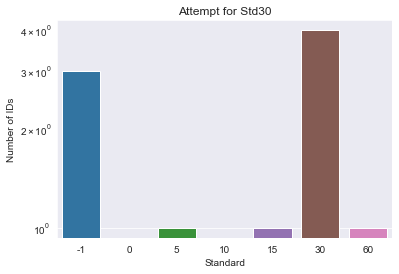

In [171]:
aligner = mp.Aligner("/data16/marcus/scripts/nanoporePipelineScripts/standardsAlignment/220902_version2.0_releventSequences.fasta", preset="map-ont")

# Change these values to effect the run:
########################################
tail_length_of_fake_standard = 30
standard_to_fake = f"ENO2_finalStandard_{tail_length_of_fake_standard:0>2}Tail"
quiet = True
number_of_iterations = 10
insert_prob_quick, delete_prob_quick, sub_prob_quick = 0.025, 0.025, 0.05
indel_size_factor_quick = 1
# ^This is inversely related to the propensity for larger and larger indels!
########################################

generated_seq_identification = {-1:0,  # For any completely unmapped
                                0:0,
                                5:0,
                                10:0,
                                15:0,
                                30:0,
                                60:0,}
iterator = tqdm(range(number_of_iterations))
for i in iterator:
    if not quiet:
        print(f"Generated Standard #{i+1:0>2}:")
    generated_seq, trunc = sequence_subindel_creater(finalStandards_dict[standard_to_fake][0], 
                                              insert_prob=insert_prob_quick,
                                              delete_prob=delete_prob_quick,
                                              sub_prob=sub_prob_quick,
                                              indel_size_factor=indel_size_factor_quick)[:]
    hits = {hit: (hit.ctg, hit.is_primary) for hit in aligner.map(generated_seq)}
    if len(hits) == 0:
        if not quiet:
            print("No hits")
        generated_seq_identification[-1] += 1
    for hit_obj, (contig, is_primary) in hits.items():
        if hit_obj.ctg != standard_to_fake and hit_obj.is_primary == 1:
            contig_hit = int(hit_obj.ctg[19:21])
            generated_seq_identification[contig_hit] += 1
            if not quiet:
                print(f"Primary: {int(hit_obj.is_primary)}, MAPQ: {hit_obj.mapq:>2}, Mismatches: {hit_obj.NM:>2}, Maps: {hit_obj.mlen:>2}, Contig: {contig_hit}nt Tail")
                print_mappy_hit_alignment(hit_obj, generated_seq, aligner.seq(hit_obj.ctg), line_print_width=50)
            for hit_obj, (contig, is_primary) in hits.items():
                contig_hit = int(hit_obj.ctg[19:21])
                if not quiet:
                    print(f"Primary: {int(hit_obj.is_primary)}, MAPQ: {hit_obj.mapq:>2}, Mismatches: {hit_obj.NM:>2}, Maps: {hit_obj.mlen:>2}, Contig: {contig_hit}nt Tail")
                if contig == standard_to_fake and not quiet:
                    pass # print_mappy_hit_alignment(hit_obj, generated_seq, aligner.seq(hit_obj.ctg), line_print_width=50)
        elif hit_obj.ctg == standard_to_fake and hit_obj.is_primary == 1:
            contig_hit = int(hit_obj.ctg[19:21])
            generated_seq_identification[contig_hit] += 1
            if not quiet:
                print("\tAccurate Match.")
pprint(generated_seq_identification)
# x_and_y = [(str(key), value) for key, value in generated_seq_identification.items()]
# x, y = zip(*x_and_y)
# ended up note using the above code, but I thought it was a cute solution
my_df = pd.DataFrame(generated_seq_identification.items())
ax = sea.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = 'Standard', ylabel='Number of IDs', title=f'Attempt for Std{standard_to_fake[19:21]}',
       yscale='log')
plt.show()

### Build a fasta file of reads generated off of the standards, with the original standard sequence as the title (plus some kind of UMI or counter)

In [182]:
# Change these values to effect the generated fasta:
####################################################
standards_to_use = [0, 5, 10, 15, 30, 60]
number_of_entries_in_fasta = 5000

insert_prob_quick = 0.01
delete_prob_quick = 0.01
sub_prob_quick = 0.05
upseq_trunc_prob_quick = 0.0001
downseq_trunc_prob_quick = 0.0001


indel_size_factor_quick = 1
output_file_name = f"{get_dt(for_file=True)}_generatedRNAStdsReads_withTruncations.fasta"
save_output = True
# ^This is inversely related to the propensity for larger and larger indels!
####################################################

fasta_storage_dict = {}
truncated_count = 0
iterator = tqdm(range(number_of_entries_in_fasta))
with open(output_file_name, 'w') as output_fasta:
    for i in iterator:
        template_standard_size = random.choice(standards_to_use)
        template_standard = f"ENO2_finalStandard_{template_standard_size:0>2}Tail"
        entry_num = f"{i+1:0>{1+int(np.ceil(np.log10(number_of_entries_in_fasta)))}}"
        generated_seq, trunc_info = sequence_subindel_creater(finalStandards_dict[template_standard][0], 
                                                  insert_prob=insert_prob_quick,
                                                  delete_prob=delete_prob_quick,
                                                  sub_prob=sub_prob_quick,
                                                  indel_size_factor=indel_size_factor_quick,
                                                  upseq_truncate_prob=upseq_trunc_prob_quick,
                                                  downseq_truncate_prob=downseq_trunc_prob_quick)[:]
        truncated_count += trunc_info[0]
        seq_id = f"RNAStd{template_standard_size:0>2}.N{entry_num} template={template_standard} entry_number={entry_num} truncated={trunc_info[0]} truncated_pos={trunc_info[1]} truncated_dir={trunc_info[2]}"
        fasta_storage_dict[seq_id] = generated_seq
        file_line = f">{seq_id}\n{textwrap.fill(generated_seq, width=5000)}\n"
        if save_output:
            output_fasta.write(file_line)
        else:
            print(file_line)
print(truncated_count)

100%|██████████| 5000/5000 [00:06<00:00, 762.94it/s]

632


#### **Next step will be to use the old standard mapping functions to see if we can get them to work with this fake data and the new standards format as designed with Levenshtein distances!**

# Assignment Method Rewrite:

In [261]:
# path_to_genome = reference_fasta
path_to_genome = "220902_version2.0_releventSequences_wOutTails.fasta"
threads = 10
fastx_file = f"220920_generatedRNAStdsReads_withTruncations.fasta"

aligner = mp.Aligner(path_to_genome,
                     preset="splice", k=14,  # These are the usual go-tos for mapping ONT dRNA-Seq
                     extra_flags=0x100000,  # From: https://github.com/lh3/minimap2/blob/master/minimap.h
                     #           0x100000 = forces strand matched alignment (b/c dRNA-seq retains strand info)
                     n_threads=threads,
                     )
if not aligner:
    # This was in the tutorial, haven't seen this yet.
    raise Exception("ERROR: failed to load/build index")

# Print the contigs (chromosomes) which in this case are the adapters in the fastq
print(f"Mapping to adapters named: {aligner.seq_names}")

seq_assignments = []  # This list will hold all the alignments eventually
assignment_counter = {-1:0,  # For any completely unmapped
                                0:0,
                                5:0,
                                10:0,
                                15:0,
                                30:0,
                                60:0,}
ground_truth_counter = {0:0,
                                5:0,
                                10:0,
                                15:0,
                                30:0,
                                60:0,}
storage_dict = {}  # This will be converted to a dataframe eventually


# If a fastx file is passed:
if isinstance(fastx_file, str):
    # Create a tqdm iterator that is going to loop through the fastx,
    #   and provide a progress bar along the way!
    
    # The total number of entries will depend on if the inputs are fastq or fasta files,
    #   so we can use the last letter of the file name to decide this:
    if fastx_file.endswith("q"):
        lines_per_entry = 4
    elif fastx_file.endswith("a"):
        lines_per_entry = 2
    else:
        raise NotImplementedError(f"The input fastx file must end in fastq/fq or fasta/fa!!")
    read_iterator = tqdm(mp.fastx_read(fastx_file, read_comment=True),
                         # The Mappy library (from Minimap2) has a fastx file reader that is very fast
                         total=sum(1 for line in open(fastx_file)) // lines_per_entry,
                         # The mappy.fastx_read iterator doesn't have a __len__, so we
                         #    have to manually tell tqdm how long the fastq will be
                         ncols=50)
    for read_id, sequence, _, comments in read_iterator:
        per_read_dict = dict(map(str.strip, sub.split('=', 1)) for sub in comments.split(' ') if '=' in sub)  # From: https://www.geeksforgeeks.org/python-convert-key-value-string-to-dictionary/
        per_read_dict['actual_std_id'] = per_read_dict.pop('template')
        original_std_tail = int(read_id[6:8])
        per_read_dict["actual_tail_length"] = original_std_tail
        original_std = per_read_dict["actual_std_id"]
        ground_truth_counter[original_std_tail] += 1
        
        # For each sequence, create empty dicts to store info about mapping hits
        hit_objs = {}
    
        # Loop through each of the mapping hits generated:
        for hit in aligner.map(sequence):
            hit_objs[hit.ctg] = hit  # and store each one
        
        # First check if there are any hits at all:
        if hit_objs:
            hit_information = {}
            for standard, hit_obj in hit_objs.items():
                assigned_std = standard[-6:-4]
                hit_information[standard] = {dir_item: eval(f"hit_obj.{dir_item}") for dir_item in dir(hit_obj) if not dir_item.startswith("__") and dir_item != "cigar"}
                per_read_dict[f"{assigned_std}_mlen"] = hit_information[standard]["mlen"]
                per_read_dict[f"{assigned_std}_NM"] = hit_information[standard]["NM"]
                per_read_dict[f"{assigned_std}_misspermap"] = hit_information[standard]["NM"] / hit_information[standard]["mlen"]
                # per_read_dict[f"{assigned_std}_hit_obj"] = hit_obj
            per_read_df = pd.DataFrame.from_dict(hit_information, orient="index")
            for test_col in ["is_primary", "mlen", "blen", "ctg_len", "mapq", "NM", "r_en"]:
                per_read_dict[f"max_{test_col}"] = int(per_read_df[test_col].idxmax()[-6:-4])
            per_read_dict['sequence'] = sequence
            # per_read_dict['was_truncated'] = False
            storage_dict[read_id] = per_read_dict
        else:  # If we are here then nothing mapped!
            assignment_counter[-1] += 1
print(assignment_counter)  # this is currently only counting failed maps lol

Mapping to adapters named: ['ENO2_finalStandard_00Tail', 'ENO2_finalStandard_05Tail', 'ENO2_finalStandard_10Tail', 'ENO2_finalStandard_15Tail', 'ENO2_finalStandard_30Tail', 'ENO2_finalStandard_60Tail']


100%|████████| 5000/5000 [00:11<00:00, 426.33it/s]

{-1: 122, 0: 0, 5: 0, 10: 0, 15: 0, 30: 0, 60: 0}


In [265]:
df = pd.DataFrame.from_dict(storage_dict, orient='index')
df['seq_len'] = df.sequence.str.len()

test_column = "max_mlen"

df['actual_tail_length'] = df.actual_tail_length.apply(lambda x: f"{x:0>2}")
df['int_actual_tail_length'] = df.actual_tail_length.astype(int)
df['assigned_tail_length'] = df.max_is_primary
df['correct_match'] = df.int_actual_tail_length == df[test_column]

df['assignment'] = df.max_mlen

compare_column = "misspermap"

df[[f'00_{compare_column}',
        f'05_{compare_column}',
        f'10_{compare_column}',
        f'15_{compare_column}',
        f'30_{compare_column}',
        f'60_{compare_column}']].idxmin(axis=1)
# df[df.truncated_dir == "down"]
# df[~df.correct_match & (df.int_actual_tail_length == df.max_mlen)]

RNAStd00.N00001    00_misspermap
RNAStd00.N00002    00_misspermap
RNAStd05.N00003    05_misspermap
RNAStd60.N00004    60_misspermap
RNAStd15.N00005    15_misspermap
                       ...      
RNAStd15.N04995    15_misspermap
RNAStd05.N04996    05_misspermap
RNAStd15.N04998    15_misspermap
RNAStd05.N04999    00_misspermap
RNAStd30.N05000    30_misspermap
Length: 4878, dtype: object

In [263]:
compare_column = "mlen"
df.loc[(df[[f'00_{compare_column}',
        f'05_{compare_column}',
        f'10_{compare_column}',
        f'15_{compare_column}',
        f'30_{compare_column}',
        f'60_{compare_column}']].nunique(axis=1, dropna=False) == 1), 'assignment'] = "ambiguous"
df[(df[[f'00_{compare_column}',
        f'05_{compare_column}',
        f'10_{compare_column}',
        f'15_{compare_column}',
        f'30_{compare_column}',
        f'60_{compare_column}']].apply(pd.Series.nlargest, axis=1, n=2).nunique(axis=1, dropna=False) == 2)][df.truncated_dir != "down"]

/tmp/ipykernel_1026487/989861092.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,entry_number,truncated,truncated_pos,truncated_dir,actual_std_id,actual_tail_length,00_mlen,00_NM,00_misspermap,60_mlen,60_NM,60_misspermap,10_mlen,10_NM,10_misspermap,15_mlen,15_NM,15_misspermap,05_mlen,05_NM,05_misspermap,30_mlen,30_NM,30_misspermap,max_is_primary,max_mlen,max_blen,max_ctg_len,max_mapq,max_NM,max_r_en,sequence,seq_len,int_actual_tail_length,assigned_tail_length,correct_match,assignment
RNAStd15.N00094,00094,False,0,NA,ENO2_finalStandard_15Tail,15,608.0,64.0,0.105263,608.0,63.0,0.103618,609.0,61.0,0.100164,611.0,59.0,0.096563,611.0,61.0,0.099836,609.0,61.0,0.100164,15,15,0,15,15,0,5,TAACACGACTCACTAAAGGGAGAACCATCAGATTTTGATTGTTAGT...,675,15,15,True,15
RNAStd00.N00183,00183,False,0,NA,ENO2_finalStandard_00Tail,00,623.0,49.0,0.078652,620.0,53.0,0.085484,623.0,55.0,0.088283,620.0,54.0,0.087097,621.0,53.0,0.085346,618.0,55.0,0.088997,10,10,10,10,10,10,10,TAATACGACTCACTCATAGGGAGAGCCATCAGATTGTGCCTGTTAG...,669,0,10,False,10
RNAStd00.N00233,00233,False,0,NA,ENO2_finalStandard_00Tail,00,625.0,40.0,0.064000,625.0,42.0,0.067200,625.0,42.0,0.067200,625.0,42.0,0.067200,624.0,42.0,0.067308,601.0,34.0,0.056572,0,0,60,0,0,60,60,TAATACGACTCACTATAGGGAGAGCCATCAGATTGTGTTTCTTAGT...,658,0,0,True,0
RNAStd00.N00456,00456,False,0,NA,ENO2_finalStandard_00Tail,00,628.0,47.0,0.074841,628.0,52.0,0.082803,606.0,41.0,0.067657,606.0,41.0,0.067657,628.0,53.0,0.084395,606.0,41.0,0.067657,15,0,5,15,15,5,60,TAATACGACTCACTATAGGGAGAGCCATCAGATTGTGTTTGTTAGT...,671,0,15,True,0
RNAStd00.N00463,00463,False,0,NA,ENO2_finalStandard_00Tail,00,615.0,57.0,0.092683,615.0,58.0,0.094309,613.0,61.0,0.099511,611.0,61.0,0.099836,612.0,61.0,0.099673,610.0,62.0,0.101639,0,0,10,0,0,30,0,TAATACGACTCACAATAGGGAGAGCCATCAGATTTGTGTTTGTTAG...,667,0,0,True,0
RNAStd30.N00547,00547,False,0,NA,ENO2_finalStandard_30Tail,30,617.0,54.0,0.087520,617.0,54.0,0.087520,622.0,51.0,0.081994,620.0,53.0,0.085484,619.0,54.0,0.087237,622.0,49.0,0.078778,30,30,10,30,30,5,30,TAATACGACTCACTATAGGGAGAGCCATCAGATAGTGTTTGTTAGT...,696,30,30,True,30
RNAStd30.N00730,00730,False,0,NA,ENO2_finalStandard_30Tail,30,607.0,51.0,0.084020,611.0,48.0,0.078560,609.0,49.0,0.080460,608.0,50.0,0.082237,614.0,49.0,0.079805,614.0,44.0,0.071661,30,30,5,30,30,0,30,TCATTCGACTCACTATAGGGAGAGCCATCAGATTGTGTTTGTTAGT...,682,30,30,True,30
RNAStd10.N00795,00795,True,493,up,ENO2_finalStandard_10Tail,10,NaN,NaN,NaN,NaN,NaN,NaN,151.0,23.0,0.152318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,10,10,10,10,10,10,GCTTCTGCCGGTAACGTCGAGTGACGAAGGTCGGTGTTGCTCAACA...,179,10,10,True,10
RNAStd00.N00902,00902,False,0,NA,ENO2_finalStandard_00Tail,00,615.0,58.0,0.094309,615.0,62.0,0.100813,614.0,61.0,0.099349,612.0,61.0,0.099673,613.0,61.0,0.099511,581.0,43.0,0.074010,30,0,60,30,30,60,60,TAATAGACTCACTATAGGGAGAGCCATCAGATTATGTTTGTTAGTC...,666,0,30,True,0
RNAStd30.N01019,01019,False,0,NA,ENO2_finalStandard_30Tail,30,604.0,63.0,0.104305,605.0,62.0,0.102479,608.0,60.0,0.098684,604.0,63.0,0.104305,606.0,64.0,0.105611,608.0,59.0,0.097039,30,30,5,30,30,5,30,TAAACGACTCACTATAGTGAGAGCCATCAGCTTGTGTTTGTTAATC...,689,30,30,True,30


## Currently, there is an issue with reads that ambiguously map between standards

These reads are accidentally assigned to a position because Mappy *really wants to give everything assignments,* and will only really not assign something if I can't remotely map it.

This is an issue in cases where the barcode is not part of the read or is too scrambled to be retained. In these cases we want to throw out these reads as ambiguous, rather than just letting them get a random assignment.

The most obvious way *(to me)* is to compare the mapping lengths (mlen) for all the standards, as if these are consistent then we are just guessing which is the best map.
    Something similar might be acheived by comparing the number of mismatches (NM) which are places that the mapper mapped but the nucleotides differ. For reads that span sequences that are identical between the difference standards (the body of the standards rather than the barcodes)

In [256]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

df['actual_tail_length'] = df.actual_tail_length.apply(lambda x: f"{x:0>2}")
df['int_actual_tail_length'] = df.actual_tail_length.astype(int)
df['assigned_tail_length'] = df.max_is_primary

# test_column = "max_mlen"

df = df[df.assignment != 'ambiguous']
df['correct_match'] = df.int_actual_tail_length == df.assignment  # df[test_column]
df['mappy_correct'] = df.int_actual_tail_length == df.assigned_tail_length


fig = px.parallel_categories(df,  #[df.truncated_dir == 'up'],
                             template='plotly_white',
                             color='int_actual_tail_length',
                             color_continuous_scale=px.colors.sequential.Inferno,
                             dimensions=["actual_tail_length",
                                         "assigned_tail_length",
                                         "correct_match",
                                         "max_mlen",
                                         "truncated",
                                         "truncated_dir",
                                         "mappy_correct"],
                             labels={"correct_match": f"Accurately Assigned (w/ {test_column})",
                                     "max_mlen": "Barcode Assigned by 'mlen' count",
                                     "actual_tail_length": "Barcode of Original Sequence",
                                     "assigned_tail_length": "Barcode Assigned Overall by Mappy (best mapq)",
                                     "max_mapq": "Barcode Assigned by 'mapq' score"})
fig.show()

/tmp/ipykernel_1026487/4150203311.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1026487/4150203311.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# FROM THE TOP: